Содержание кода
I) Все импорты
II) Тренировка новой модели
III) Дообучение модели с учетом новых пакетов
IV) Аналитика

I) Все импорты

In [1]:
from geopandas import GeoDataFrame, read_file
from geopandas.array import points_from_xy
from geopandas.datasets import get_path
from numpy import ndarray
from pandas import DataFrame, concat
from pandas.plotting import scatter_matrix
from requests import get, post
from os import listdir, makedirs
from os.path import join, exists
from pickle import dump, load
from re import findall, search
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure, scatter, xlabel, ylabel

II) Тренировка новой модели (при наличии пакетов в локальной памяти)
    1) Загрузить информацию об уже имеющихся пакетах (def load_local_packets)
    2) Подготовить пакеты к тренировке модели (def preprocessing_packets)
    3) Обучить модель (def fit_model)
    4) Сохранить модель (def save_model)
    5) Вызов функций (пп 1-4)

In [2]:
# II) 1) Загрузить информацию об уже имеющихся пакетах (1 файл - 1 пакет)
def load_local_packets(directory_:str= "packets/")->[{}]:
    """
    Загрузить информацию о пакетах с компьютера
    :param directory_: Место хранения информации о пакетах
    :return: Список необработанных пакетов
    """
    assert exists(directory_), "Не найдена директория для загрузки пакетов"

    # Сортировка файлов так, чтобы 2.bin был раньше 10.bin, 105.bin и тд)
    files_packets = sorted(listdir(directory_), key=(lambda n_bin: int(search('\d+', n_bin)[0])))

    # список с информацией о всех пакетах
    packets_ = []

    for file_name in files_packets:
        # Считывание из бинарного файла информации об одном пакете
        with open(join(directory_, file_name), 'rb') as f_:
            packet = load(f_)
        # Добавление информации об одном пакете в список с информацией о всех пакетах
        packets_.append(packet)

    return packets_

In [3]:
# II) 2) Подготовить пакеты к тренировке модели

In [4]:
# Нужно для предобработки meta6
def data_from_ip(ip: str) -> dict:
    """
    Возвращает данные по IP-адресу
    :param ip: IP-адрес
    :return: Данные извлеченные из IP
    """
    # По этому адресу можно извелчь информацию о местоположении по IP
    url = "https://geolocation-db.com/json/" + ip

    data_from_ip_req = get(url)
    if data_from_ip_req.status_code == 200:
        # json содержит 'country_code', 'country_name', 'city',
        # 'postal', 'latitude', 'longitude', 'IPv4', 'state'
        return data_from_ip_req.json()
    else:
        # Не получилось взять информацию из IP адреса
        return {}

In [5]:
# Фиксированные признаки
meta1_features = ['REQUEST_ARGS', 'REQUEST_HEADERS', 'REQUEST_GET_ARGS',
                  'REQUEST_POST_ARGS', 'REQUEST_PATH', 'REQUEST_COOKIES',
                  'REQUEST_URI', 'REQUEST_ARGS_KEYS', 'RESPONSE_HEADERS',
                  'REQUEST_METHOD', 'REQUEST_CONTE', 'CLIENT_USERAGENT',
                  'CLIENT_SESSION_ID', 'RESPONSE_BODY', 'REQUEST_HEADE',
                  'REQUEST_XML', 'REQUEST_JSON', 'REQUEST_QUERY',
                  'REQUEST_FILES', 'REQUEST_CONTENT_TYPE']
meta2_features = ['action', 'pwd', 'User-Agent', 'id', 'src', 'query', 'path', 'reference to',
                   'url', 'Referer', 'anj',  'pic', 'Location', 'REQUEST_GET_ARGS._',
                  'option', 'goto', 'page', 'Connection', 'REQUEST_PATH']
meta3_features = [200, 206, 301, 302, 304, 400, 403, 404, 405, 502, 503, 504]
meta4_features = ['mb_time']
# Популярные
meta5_features = ['ahrefs', 'megaindex', # seo
                  'applewebkit', 'openvas',  'clr', 'trident', 'winhttp', 'winhttprequest', # software
                  'win', 'windows', 'nt', 'linux', 'x', 'android', 'mac', # os
                  'msie', 'chrome', 'firefox', 'yabrowser', 'safari', # browser
                  'wow', # may be game
                  'yandex', 'google', # search
                  'robot', 'bots', 'ahrefsbot', 'yandexbot', # bots
                  'print', 'mobile', 'compatible', 'like', 'http', 'gecko' # other
                  ]
# Популярные
meta6_features = ['Moscow', 'St Petersburg', 'Orenburg', 'Frankfurt am Main',
                  'Tokyo', 'Frankfurt am Main', 'Yekaterinburg', 'Perm', 'Izhevsk',
                  'Podolino', 'Sevastopol', 'Krasnogorsk', 'Khanty-Mansiysk', 'Boardman',
                  'Arzamas', 'Krasnodar', 'Kyiv', 'Kirov']
vector_features = ['len', 'words', 'spaces']

feature_names = meta1_features + meta2_features + meta3_features + meta4_features + meta5_features + meta6_features + vector_features

In [7]:
def preprocessing_packets(packets_:[{}]) -> DataFrame:
    """
    Предобработка набора данных
    :param packets_: Информация о пакетах
    :return: Таблица предобработанных данных о пакетах
    """
    # Таблица пакетов (каждая строка - пакет, каждый столбец - признак)
    x_table_ = []
    for i_, packet in enumerate(packets_):
        try:
            x_row = []

            # meta1
            # Содержит ли packet['meta1'] подстроку meta (int(True)==1, int(False)==0)
            x_row.extend([int(meta in packet['meta1']) for meta in meta1_features])

            # meta2
            x_row.extend([int(packet['meta2'] == meta) for meta in meta2_features])

            # meta3
            # статус-коды запроса == meta ?
            x_row.extend([int(packet['meta3'] == meta) for meta in meta3_features])

            # meta4
            # Числовое значение
            x_row.append(packet['meta4'])

            # meta5
            # Названия приложений (Пока без учета версии)
            meta5_lower = packet['meta5'].lower()
            x_row.extend([int(meta in meta5_lower) for meta in meta5_features])

            # meta6
            # Получить данные из пакета
            all_data_from_ip = data_from_ip(ip=packet['meta6'])
            # Получить название города по IP-адресу пакета
            city = all_data_from_ip['state']

            x_row.extend([int(meta == city) for meta in meta6_features])

            # vector
            vector_len = len(packet['vector']) # Число символов в vector
            vector_words = len(findall(r"[A-z]+", packet['vector'])) # Число слов в vector
            vector_spaces = len(findall(r"[ ]+", packet['vector'])) # Число проелов в vector
            x_row.extend([vector_len, vector_words, vector_spaces])

            x_table_.append(x_row)

        except KeyError:
            # Если вдруг придет какой-нибудь корявый пакет (без какого-нибудь metaN), его нужно поймать
            print("ИСКЛЮЧЕНИЕ")
            print(i_, "пакет id =", packet['id'])

    # Добавление строк закончено, поэтому можно конвертировать в DataFrame
    x_table_ = DataFrame(x_table_, columns=feature_names)

    # Стандартизация для столбцов с числовыми значениями
    sc = StandardScaler()
    x_table_[meta4_features + vector_features] = sc.fit_transform(x_table_[meta4_features + vector_features])

    return x_table_

In [8]:
# II) 3) Обучить модель
def fit_model(x_table_:DataFrame, cluster_centers_:ndarray=None):
    """
    Тренировка новой модели
    :param cluster_centers_: Центроиды кластеров
    :param x_table_: Набор данных
    :return: Модель
    """
    # Число кластеров должно быть меньше количества объектов из набора данных
    n_clusters = min(50, len(x_table_) - 1)

    # Инициализация модели
    model_ = KMeans(n_clusters=n_clusters, init='k-means++', n_init=100, random_state=0)

    # Установить заданные центроиды
    if cluster_centers_ is not None:
        model_.cluster_centers_ = cluster_centers_

    # Обучить модель
    model_.fit(x_table_)

    return model_

In [9]:
# II) 4) Сохранить модель
def save_model(model_, directory_:str= "model/", file_name:str= "model.bin"):
    """
    Запись новой или дообученной модели в память
    :param model_: Модель для записи на диск
    :param directory_: Директория, где будет храниться файл модели
    :param file_name: Название файла, в который будет записана модель
    :return:
    """
    # Если директория не создана, создать
    if not exists(directory_):
        makedirs(directory_)
    file_models = join(directory_, file_name)
    # Запись модели в память
    with open(file_models, 'wb') as f_:
        dump(model_, f_)

In [10]:
# II) 5) Вызов функций (пп 1-4)
packets = load_local_packets()
print("1) Пакеты загружены с диска")

x_table = preprocessing_packets(packets_=packets[:300])
print("2) Пакеты подготовлены к обучению")

model = fit_model(x_table_=x_table)
print("3) Модель обучена")

save_model(model_=model)
print("4) Модель сохранена на диск")

1) Пакеты загружены с диска
2) Пакеты подготовлены к обучению
3) Модель обучена
4) Модель сохранена на диск


III) Дообучение модели с учетом новых пакетов
    1) Загрузить уже обученную модель из локального хранилища (def load_models)
    2) Скачать N пакетов (def download_packets)
    3) Предобработать пакеты, подготовить к предсказанию (preprocessing_packets из II.2)
    4) Предсказать метки с помощью имеющейся модели (def predict_labels)
    5) Отправить метки пакетов на сервер (def send_labels)
    6) Сохранить новые пакеты в память (def save_new_packets)
    7) Объединить данные новых и старых пакетов (def concat_old_and_new_x_table)
    8) Дообучить модель с помощью набора объединенных пакетов (def fit_models из II.3)
    9) Сохранить модель (def save_model из II.4)
    10) Вызов функций (пп 1-9)

In [11]:
# III) 1) Загрузить уже обученную модель из локального хранилища
def load_model(file_name:str= 'model/model.bin'):
    """
    Загрузить обученные модели
    :param file_name: Полное имя файла со обученной моделью
    :return: Обученная модель
    """

    if exists(file_name):
        with open(file_name, 'rb') as f_:
            # Модель
            return load(f_)

    return None

In [12]:
# III) 2) Скачать N пакетов
def download_packets(n_new_packets:int=1) -> [{}]:
    """
    Скачать новые пакеты
    :param n_new_packets: Количество пакетов
    :return:
    """
    new_packets_ = []
    for i_ in range(n_new_packets):
        # Запрос для получения инормации о случайном пакете
        packet_req = get(
            "https://slot-ml.com/api/v1/users/cfd22d44872337b82e6377d455aa85abb33c76e2/vectors/?random")

        # Если запрос успешен
        if packet_req.status_code == 200:
            new_packets_.append(packet_req.json())

    return new_packets_

In [13]:
# III) 3) Предобработать и подготовить пакеты к предсказанию (Фукнция из II.2)

In [14]:
# III) 4) Предсказать метки с помощью имеющейся модели
def predict_labels(model_, x_table_) -> ndarray:
    """
    Предсказать метки новых пакетов
    :param model_: Модель
    :param x_table_: Новые данные
    :return:
    """
    model_.predict(x_table_)

    # Вернуть только новые метки (+1, т.к. от 1 до 50)
    return model_.labels_[-len(x_table_):] + 1

In [15]:
# III) 5) Отправить метки пакетов на сервер
def send_labels(packets_:[{}], labels_:ndarray):
    """
    Отправка меток пакетов
    :param packets_: Рассматриваемые пакеты
    :param labels_: Номера кластеров, к которым принадлежат объекты
    :return:
    """

    assert len(packets_) == len(labels_), "Количество пакетов не совпадает с количеством меток"

    # URL для отправки post-запросов
    url_for_target = "https://slot-ml.com/api/v1/users/cfd22d44872337b82e6377d455aa85abb33c76e2/results/"

    # Цикл по пакетам
    for i_, packet in enumerate(packets_):
        # Отправка post-запроса (отправка предсказанной метки пакета)
        post(url_for_target, json={ "vector": packet['id'], "class": int(labels_[i_]) })

In [16]:
# III) 6) Сохранить новые пакеты в память
def save_new_packets(new_packets_:[{}], directory_:str= "packets/"):
    """
    Сохранение новых пакетов на диск
    :param new_packets_: Новые пакеты
    :param directory_: Директория, в которую сохранить
    :return:
    """
    for packet_ in new_packets_:
        # Для уникальности название файла - (номер файла).bin
        with open(join(directory_, str(len(listdir(directory_))) + ".bin"), 'wb') as f_:
            dump(packet_, f_)

In [17]:
# III) 7) Объединить данные новых и старых пакетов
def concat_old_and_new_x_table(old_x_=DataFrame, new_x_=DataFrame) -> DataFrame:
    """
    Объединить два DataFrame
    :param old_x_: 1st DataFrame
    :param new_x_: 2nd DataFrame
    :return: Объединенный DataFrame
    """
    ... # Возможно, здесь будет проверка на их соответсвие, на не None и тд.
    return concat([old_x_, new_x_], ignore_index=True)

In [18]:
# III) 8) Дообучить модель с помощью старых и новых пакетов (def fit_models из II.3)

In [19]:
# III) 9) Сохранить модель (Функция из II.4)

In [20]:
# III) 10) Вызов функций (пп 1-9)
# Для уменьшения времени обработки лучше получать и обрабатывать по одному пакету

model = load_model()
# print("1) Модель подготовлена")

N = 10 # Число пакетов
for i in range(N):

    new_packets = download_packets(n_new_packets=1)
    # print("2) Пакеты скачаны с сервера")

    new_x_table = preprocessing_packets(packets_=new_packets)
    # print("3) Пакеты подготовлены к обучению")

    labels = predict_labels(model_=model,x_table_=new_x_table)
    # print("4) Метки новых пакетов предсказаны")

    send_labels(new_packets, labels)
    # print("5) Метки новых пакетов отправлены")

    save_new_packets(new_packets_=new_packets)
    # print("6) Новые пакеты сохранены")

    x_table = concat_old_and_new_x_table(old_x_=x_table, new_x_=new_x_table)
    # print("7) Данные новых и старых пакетов объединены")


# Переобучить модель, используя предыдущие центроиды кластеров
model = fit_model(x_table_=x_table, cluster_centers_=model.cluster_centers_)
# print("8) Модель дообучена")

save_model(model_=model)
# print("9) Модель сохранена на диск")

IV) Аналитика
    1) Статистика с сайта https://slot-ml.com
    2) Добавление меток в общую таблицу
    3) Несколько случайных объектов
    4) Средние значения признаков в классах
    5) Зависимость некоторых признаков в 2-мерном представлении
    6) Матрица рассеяния и гистограмма
    7) Матрица корреляции
    8) Зависимость некоторых признаков в 3-мерном представлении
    9) Показать на карте, откуда отправлены пакеты

In [21]:
# IV) 1) Статистика с сайта
my_stat = get("https://slot-ml.com//api/v1/users/cfd22d44872337b82e6377d455aa85abb33c76e2/stats")
my_stat.json()

{'stats': [{'total_vectors': 1933,
   'attempt_number': 5,
   'avg_false_positive_ratio': 1.20416,
   'avg_user_level': 1,
   'avg_spent_time': 27.9874,
   'total_results': 1827,
   'avg_accuracy': 25.561,
   'classify_data_ratio': 94.5163,
   'avg_false_negative_ratio': 67.2687}]}

In [22]:
# IV) 2) Добавление меток в общую таблицу
x_for_stat = x_table.copy()
x_for_stat['label'] = model.labels_

In [23]:
# IV) 3) Несколько случайных объектов
x_for_stat.sample(5)

,REQUEST_ARGS,REQUEST_HEADERS,REQUEST_GET_ARGS,REQUEST_POST_ARGS,REQUEST_PATH,REQUEST_COOKIES,REQUEST_URI,REQUEST_ARGS_KEYS,RESPONSE_HEADERS,REQUEST_METHOD,...,Khanty-Mansiysk,Boardman,Arzamas,Krasnodar,Kyiv,Kirov,len,words,spaces,label
174,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,-0.347489,-0.192175,-0.328398,25
286,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.086850,-0.133881,1.164322,11
258,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.436450,-0.250469,-0.464100,13
293,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.714810,0.361615,1.164322,8
183,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.473081,-0.367056,-0.464100,28


In [24]:
# IV) 4) Средние значения признаков в классах
x_for_stat.groupby('label').mean()

# Рискну предположить:
# если в такой таблице в столбце категориального признака
# среднее значение одного класса->1, а других->0,
# значит этот признак сильно влияет на прогноз в данной модели

,REQUEST_ARGS,REQUEST_HEADERS,REQUEST_GET_ARGS,REQUEST_POST_ARGS,REQUEST_PATH,REQUEST_COOKIES,REQUEST_URI,REQUEST_ARGS_KEYS,RESPONSE_HEADERS,REQUEST_METHOD,...,Krasnogorsk,Khanty-Mansiysk,Boardman,Arzamas,Krasnodar,Kyiv,Kirov,len,words,spaces
label,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.483547,-0.275452,-0.464100
1,0.000000,0.933333,0.000000,0.000000,0.000000,0.000,0.066667,0.000000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.332487,-0.330137,0.096801
2,1.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.240212,-0.192175,-0.464100
3,0.000000,0.000000,0.000000,0.000000,0.000000,1.000,0.000000,0.000000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.703351,2.367891,1.141705
4,1.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.324463,-0.294189,-0.396249
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,1.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.195732,-0.279616,-0.328398
6,0.000000,0.000000,0.000000,1.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.610634,-0.500299,-0.464100
7,0.000000,0.000000,0.800000,0.000000,0.100000,0.100,0.000000,0.000000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.586114,-0.509876,-0.450530
8,1.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.737051,0.368902,1.164322


Text(0, 0.5, 'words')

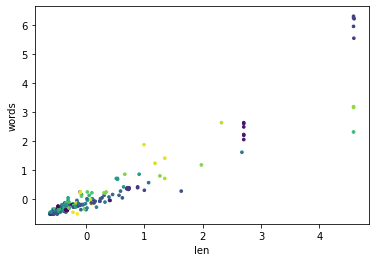

In [25]:
# IV) 5) Зависимость некоторых признаков в 2-мерном представлении
feat_x = vector_features[0] # 'len'
feat_y = vector_features[1] # 'words'
scatter(x=x_for_stat[feat_x], y=x_for_stat[feat_y], c=x_for_stat["label"], s=7)
xlabel(feat_x)
ylabel(feat_y)
# По осям разные значения признаков, одинаковые цвета из одного кластера

array([[<AxesSubplot:xlabel='len', ylabel='len'>,
        <AxesSubplot:xlabel='words', ylabel='len'>,
        <AxesSubplot:xlabel='spaces', ylabel='len'>],
       [<AxesSubplot:xlabel='len', ylabel='words'>,
        <AxesSubplot:xlabel='words', ylabel='words'>,
        <AxesSubplot:xlabel='spaces', ylabel='words'>],
       [<AxesSubplot:xlabel='len', ylabel='spaces'>,
        <AxesSubplot:xlabel='words', ylabel='spaces'>,
        <AxesSubplot:xlabel='spaces', ylabel='spaces'>]], dtype=object)

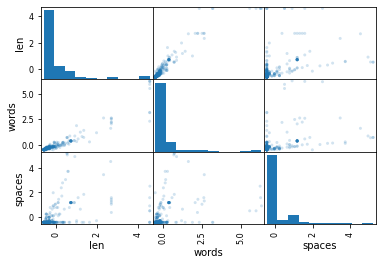

In [26]:
# IV) 6) Матрица рассеяния и гистограмма
feat_x = vector_features[0] # 'len'
feat_y = vector_features[1] # 'words'
feat_z = vector_features[2] # 'spaces'
scatter_matrix(x_for_stat[[feat_x, feat_y, feat_z]], alpha=0.2)

In [27]:
# IV) 7) Матрица корреляции
feat_x = vector_features[1] # 'words'
feat_y = vector_features[0] # 'len'
col = [feat_x, feat_y]
x_for_stat[col].corr()

,words,len
words,1.000000,0.940575
len,0.940575,1.000000


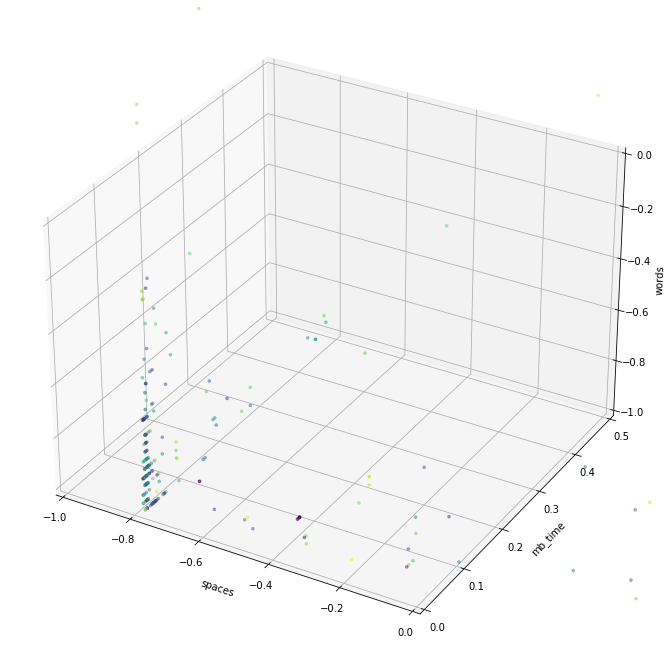

In [28]:
# IV) 8) Зависимость некоторых признаков в 3-мерном представлении
feat_x = vector_features[2] # 'spaces'
feat_y = meta4_features[0] # 'mb_time'
feat_z = vector_features[1] # 'words'
ax = Axes3D(figure(figsize=(12, 9)))
ax.set_xlabel(feat_x)
ax.set_ylabel(feat_y)
ax.set_zlabel(feat_z)

ax.set_xlim(-1, 0)
ax.set_ylim(0, 0.5)
ax.set_zlim(-1, 0)
ax.scatter(xs=x_for_stat[feat_x], ys=x_for_stat[feat_y], zs=x_for_stat[feat_z], c=x_for_stat["label"], s=7, alpha=0.4)

<AxesSubplot:>

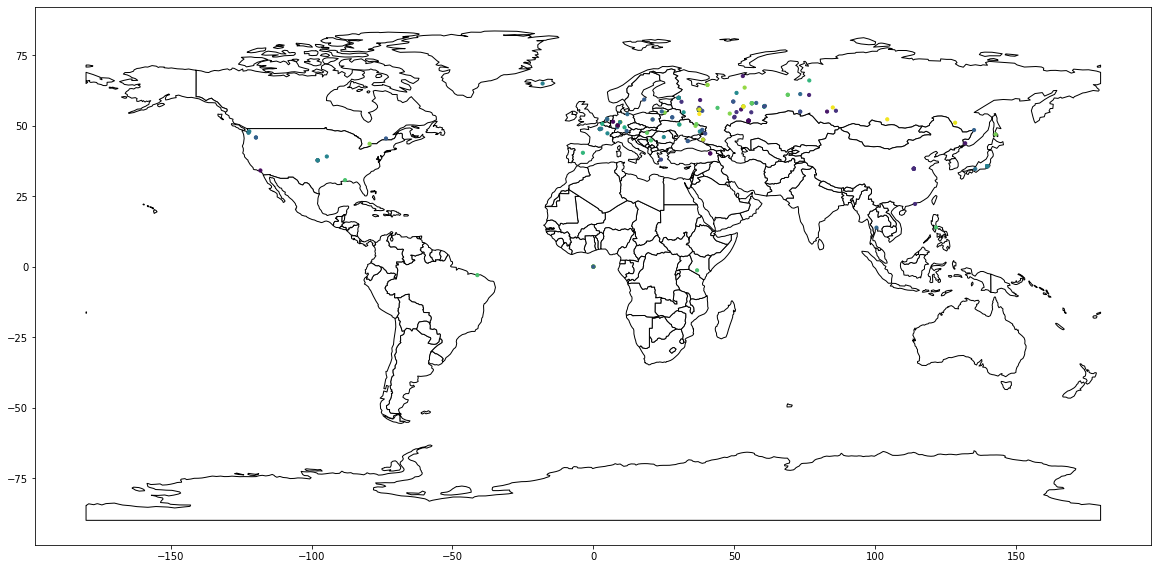

In [46]:
# IV) 9) Показать на карте, откуда отправлены пакеты
# Загрузить из БД Информацию по IP пакетам
with open("data_from_ip/data_from_ip_list.bin", 'rb') as f:
    data_from_ip_list = load(f)

# Все широты адреса пакета
longitude_list = [jso['longitude'] for jso in data_from_ip_list]
# Все долготы адреса пакета
latitude_list = [jso['latitude'] for jso in data_from_ip_list]
# Не все координаты найдены
for i in range(len(x_for_stat)):
    if longitude_list[i] == 'Not found' or latitude_list[i] == 'Not found':
        longitude_list[i] = latitude_list[i] = 0.

# Точки, чтобы расставить на карте
gdf = GeoDataFrame(geometry=points_from_xy(longitude_list, latitude_list))

# Отобразить
world = read_file(get_path('naturalearth_lowres'))
# Нарисовать весь мир
ax = world.plot(color='white', edgecolor='black', figsize=(20, 15))
# Расставить точки на карте (одинаковые цвета - один кластер)
gdf.plot(ax=ax, c=x_for_stat["label"], markersize=10)